In [1]:
import pandas as pd
import numpy as np
import hrvanalysis as hrv
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import scipy.stats as ss
import peakutils as pu

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
sb.set(font_scale=1)

In [16]:
ecg_data = sorted(glob.glob('*.csv', recursive=True))[-1]

In [17]:
df_ecg = pd.read_csv(ecg_data, header=None, sep=' ', names=['x', 'y'], index_col=0, dtype=np.int)
df_peaks = df_ecg.iloc[pu.indexes(df_ecg.values.ravel(), thres=(np.median(df_ecg) + np.diff(np.quantile(df_ecg, [0.25, 0.75]))[0] * 1.5), min_dist=350, thres_abs=True)]
#df_peaks = df_peaks[df_peaks > 500].dropna()

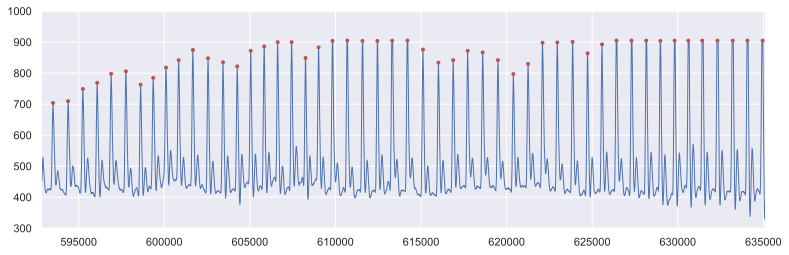

In [24]:
plt.figure(figsize=(13,4))
plt.ylim(300, 1000)
plt.xlim(df_ecg.index.min(), df_ecg.index.max())
plt.plot(df_ecg.index.values, df_ecg.values.ravel(), lw=1)
plt.plot(df_peaks.index.values, df_peaks.values.ravel(), 'ro', ms=3)

## RR intervals

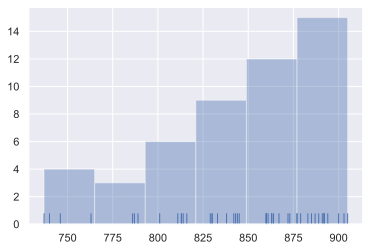

In [26]:
rr = np.diff(df_peaks.index)
sb.distplot(rr, bins=6, kde=False, rug=True)

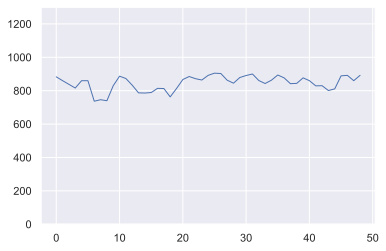

In [27]:
plt.ylim(0, 1300)
sb.lineplot(range(len(rr)), rr, lw=1)

In [28]:
nn = np.array(hrv.get_nn_intervals(rr))
nn = nn[~np.isnan(nn)]

0 outlier(s) have been deleted.
0 ectopic beat(s) have been deleted with kamath rule.


## Features 

In [29]:
fdf = hrv.get_frequency_domain_features(nn)
fdf

{'lf': 748.4760356257374,
 'hf': 334.8966691356107,
 'lf_hf_ratio': 2.2349461926796734,
 'lfnu': 69.08758475603427,
 'hfnu': 30.912415243965718,
 'total_power': 1615.8330124622341,
 'vlf': 532.460307700886}

In [30]:
ccf = hrv.get_csi_cvi_features(nn)
ccf

{'csi': 2.169524456345105,
 'cvi': 4.369824666441991,
 'Modified_csi': 489.1692609358282}

In [31]:
tdf = hrv.get_time_domain_features(nn)
tdf

{'mean_nni': 846.1020408163265,
 'sdnn': 43.88870626271599,
 'sdsd': 36.359120961367225,
 'nni_50': 5,
 'pnni_50': 10.204081632653061,
 'nni_20': 25,
 'pnni_20': 51.02040816326531,
 'rmssd': 36.35960441662331,
 'median_nni': 860.0,
 'range_nni': 168,
 'cvsd': 0.042973072587726244,
 'cvnni': 0.05187164685286871,
 'mean_hr': 71.11036541859362,
 'max_hr': 81.41112618724559,
 'min_hr': 66.29834254143647,
 'std_hr': 3.8429307113170563}

In [32]:
hrv.get_poincare_plot_features(nn)

{'sd1': 25.981849740875777,
 'sd2': 56.368258433913724,
 'ratio_sd2_sd1': 2.169524456345105}

# HRV score and Stress index (Baevsky, 2009)

In [33]:
hrv_score = 20*np.log(tdf['rmssd'])

mode = ss.mode(rr)[0][0]
hist = np.histogram(nn, bins=np.arange(0, 2500, 50))
mid1 = np.argwhere(hist[1] > mode)[0][0] - 1
mid2 = mid1 + 1
amo = (hist[0][mid1:mid2].item() / len(nn)) * 100
isb = amo / (2 * mode) / (np.max(nn) - np.min(nn)) * 1000 * 1000

hrv_score, isb

(71.86916779238545, 169.50301715370534)

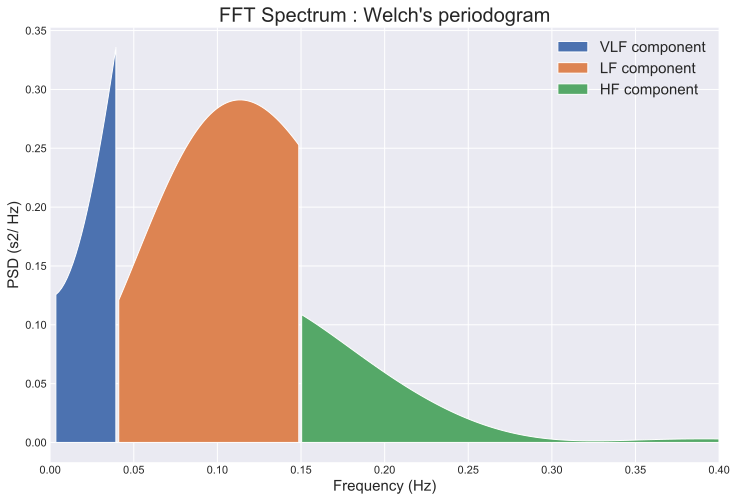

In [97]:
hrv.plot.plot_psd(rr)